# ANÁLISIS BIVARIADO DE SERIES DE TIEMPO (BITCOIN Y ETHEREUM) USANDO REDES RNN-LSTM MULTIPASO

#### Análisis bidimensional (bivariado) y multipaso de las series de tiempo del precio de Bitcoin y del Ethereum.

### Cambios respecto a los modelos a un paso:
- Creación de la función 'multi_step_plot'.
- Visualización de las predicciones de cada paso.

<a name="contents"></a>
# Contenido

- [Notas, desconexión y librerías](#conecct)
- [Importando y visualizando datos del Bitcoin y Ethereum](#data)
- [Selección y visualización de datos a tratar](#select&PlottingData)
- [Definiendo hiperparámetros y estandarizando los datos](#hyper&Standard)
- [Función de preparación de datos (multivariate_data)](#multivariate_data)
- [Distribución de los datos (entrenamiento y validación) y transformación de estos al formato de TensorFlow](#Distr&TFFormat)
- [Funciones para graficar predicción y pérdida](#plotFuncts)
- [Función(es) de creación del modelo RNN-LSTM](#modelFunct)
- [PRIMEROS MODELOS: Con 8, 128 y 256 neuronas.](#1stModels)
- [Formato de las predicciones multipaso en un modelo con 8 neuronas](#multistepPred)
- [Primeras gráficas: Graficando predicciones (de 8, 128 y 256 neuronas) y mostrando errores (MSE)](#1stPredPlots)
- [SEGUNDOS MODELOS (PROBLEMA): Predicciones de modelos "iguales" (con 128 y 512 neuronas)](#sameModels)
- [Caracterizando el error (MSE) con modelos bivariados de 256 neuronas ](#Errors)
- [Conclusiones e ideas](#Conclu)

<a name="conecct"></a>
# Notas, desconexión y librerías:
- La primera celda es un código que en teoría evita la desconexión de Colab.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#Source: https://towardsdatascience.com/10-tips-for-a-better-google-colab-experience-33f8fe721b82#0d57
#Stop Colab from disconecting:
#ctl+shift+i -> console -> command lines:
#Ctrl+ Shift + i to open inspector view . Then goto console.

function ConnectButton(){
    console.log("Working"); 
    document.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

### *Importando paquetes:*

In [ ]:
#To import data
#!pip install pandas_datareader #For COLAB #Use if yfinance does not work #import pandas_datareader.data as web
#installing yfinance (Colab)
!pip install yfinance
#pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
#For Bootstrap
!pip install dc_stat_think
import dc_stat_think as dcst
#To use goodness fit test
from scipy import stats
import random
#Data managing
import numpy as np
import os
import pandas as pd
#To comparison forecasts
from sklearn.metrics import mean_squared_error
#Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
#RNN
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

#I dont know for what are these packages
import seaborn as sns
import time
import gc
import sys

print(f"Tensorflow Version: {tf.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Numpy Version: {np.__version__}")
print(f"System Version: {sys.version}")

#Setting figure size
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

     |████████████████████████████████| 6.3 MB 40.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=8f75468848ef4b666979de41d261d08c46a1c2d7980f144745c44adf65601c3e
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
Tensorflow Version: 2.5.0
Pandas Version: 1.1.5
Numpy Version: 1.19.5
System Version: 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]


<a name="data"></a>
# Importando y visualizando datos del Bitcoin y Ethereum:
## Registros diarios (uno por día)
Como se puede ver hay se tienen 2160 registros diarios del Bitcoin y Ethereum desde el 2015 hasta la fecha, por eso la diferencia con los 2481 a analizar solo el Bitcoin, ya que el Ethereum no cotiza desde el 2014:

Volver a [Tabla de contenidos](#contents).

In [ ]:
#Bivariate time series
print("--------------------------DATA--------------------------")
#Import this data is redundant, because it is done later
#df_adj = pdr.get_data_yahoo(["BTC-USD", "ETH-USD"]).dropna()["Adj Close"]
data = pdr.get_data_yahoo(["BTC-USD", "ETH-USD"]).dropna()
features = data["Adj Close"]

print(type(features))
print("---------------------------Head & Tail----------------------------")
print(data.head(2))
print(features.head(2))
print(features.tail(2))
print("---------------------------Description----------------------------")
#NOTE: Check that index is date by default
print(type(features.index))
print(features.describe())
#df_adj.sort_index(ascending=False).head()

--------------------------DATA--------------------------
[*********************100%***********************]  2 of 2 completed
<class 'pandas.core.frame.DataFrame'>
---------------------------Head & Tail----------------------------
             Adj Close                 Close  ...     Open    Volume          
               BTC-USD   ETH-USD     BTC-USD  ...  ETH-USD   BTC-USD   ETH-USD
Date                                          ...                             
2015-08-07  279.584991  2.772120  279.584991  ...  2.83162  42484800  164329.0
2015-08-08  260.997009  0.753325  260.997009  ...  2.79376  58533000  674188.0

[2 rows x 12 columns]
               BTC-USD   ETH-USD
Date                            
2015-08-07  279.584991  2.772120
2015-08-08  260.997009  0.753325
                 BTC-USD      ETH-USD
Date                                 
2021-07-19  30817.832031  1817.296631
2021-07-20  29613.970703  1777.918945
---------------------------Description----------------------------


<a name="select&PlottingData"></a>

#Selección y visualización de datos a tratar.
### Seleccionando los datos de la serie de tiempo a analizar
- Seleccionando los datos de cierre.
- Gráfica de los datos de entrenamiento y validación.
- Extrayendo los valores del dataframe (se deja de trabajar con un dataframe, y se pasa a trabajar con un array).

Volver a [Tabla de contenidos](#contents).

[*********************100%***********************]  2 of 2 completed


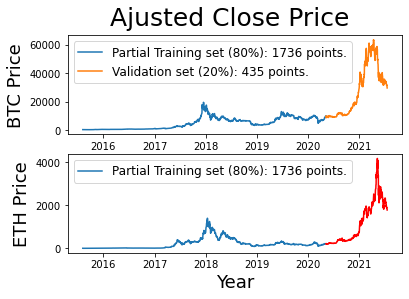

In [ ]:
#df_adj = pdr.get_data_yahoo(["BTC-USD", "ETH-USD"]).dropna()["Adj Close"]
data = pdr.get_data_yahoo(["BTC-USD", "ETH-USD"]).dropna()
features = data['Adj Close']

#Hiperparameter
TRAIN_SPLIT = int(len(features)*0.8)
#print(TRAIN_SPLIT)

#if it does not work, includ date as index
fig, axs = plt.subplots(2)
fig.suptitle("Ajusted Close Price", size=25)
#fig.suptitle("Precio de cierre ajustado", size=25)
#----- Bitcoin plot ---------
axs[0].set_ylabel('BTC Price', fontsize=18)
#axs[0].set_ylabel('Precio BTC (USD)', fontsize=18)
axs[0].plot(features['BTC-USD'][:TRAIN_SPLIT], label="Partial Training set (80%): "+str(TRAIN_SPLIT)+" points.")
axs[0].plot(features['BTC-USD'][TRAIN_SPLIT:], label="Validation set (20%): "+str(len(features)-TRAIN_SPLIT)+" points.")
#axs[0].plot(features['BTC-USD'][:TRAIN_SPLIT], label="Conjunto de entrenamiento parcial (80%): "+str(TRAIN_SPLIT)+" datos.")
#axs[0].plot(features['BTC-USD'][TRAIN_SPLIT:], label="Conjunto de validación (20%): "+str(len(features)-TRAIN_SPLIT)+" datos.")
axs[0].legend(fontsize = 12)
#----- Ethereum plot ---------
axs[1].set_ylabel('ETH Price', fontsize=18)
#axs[1].set_ylabel('Precio ETH (USD)', fontsize=18)
axs[1].plot(features['ETH-USD'][:TRAIN_SPLIT], label="Partial Training set (80%): "+str(TRAIN_SPLIT)+" points.")
#axs[1].plot(features['ETH-USD'][:TRAIN_SPLIT], label="Conjunto de entrenamiento parcial (80%): "+str(TRAIN_SPLIT)+" datos.")
axs[1].plot(features['ETH-USD'][TRAIN_SPLIT:], color="red")#, label="Validation set (20%): "+str(len(features)-TRAIN_SPLIT)+" points.")
axs[1].legend(fontsize = 12)
axs[1].set_xlabel('Year', fontsize = 18)
#axs[1].set_xlabel('Año', fontsize = 18)
plt.show()
#print(data.describe())


<a name="hyper&Standard"></a>
# Definiendo hiperparámetros (para la red LSTM) y estandarizando los datos
- *Idea:* Crear una función de estandarización para exportar).
- La estandarización se hace con los datos de entrenamiento.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#-------------------- HYPERPARAMETERS ----------------------
#Data load params
BATCH_SIZE = 256
BUFFER_SIZE = 10000
#TRAIN_SPLIT = int(len(btc_usd)*0.8) #Put before
#print(TRAIN_SPLIT)
#print(type(TRAIN_SPLIT))


#LSTM params
EVALUATION_INTERVAL = 200 #FOR WHAT?
EPOCHS = 100
PATIENCE = 5 #FOR WHAT?

#Seeding for reproducibility
SEED = 13
tf.random.set_seed(SEED)

#-------------------- STANDARIZATION ----------------------
#Getting mean and std
dataset = features.values
#print(dataset)
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
#print(data_mean)
#print(data_std)

#standarized dataset
dataset = (dataset-data_mean)/data_std
#print(dataset)
#print(dataset.dtype)
#print(dataset[:,0]) #To understand 'target' in single step model


<a name="multivariate_data"></a>
# Función de preparación de datos (multivariate_data):
- Para análisis multivariado, datos ya estandarizados o normalizados.
- *Idea:* Candidata a exportar.

Volver a [Tabla de contenidos](#contents).

In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
  '''
      dataset: Data "matrix" containing the all time series (stadarized or not)
      target: Data (point in single step model) to predict
      start_index: index from where data start to analize
      end_index: final index to take data. None is to take all data
      history_size: window size to create sequence (and then used to predict)
      target_size: position of point in future 'until where' (hasta donde) to predict
      step: (Provitional) step(1,2,etc) in indices to take data from dataset
      single_step: TRUE=>single step model FALSE=> multi step model
  '''
  data = []
  labels = []
  
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  
  for i in range(start_index, end_index):
    indices = range(i-history_size,i,step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  
  return np.array(data), np.array(labels)

#print(len(range(0,10,2)))

In [ ]:
#Understanding 'STEP' (NOTE: STEP must be >= 1)
step_test = 1
#print(len(range(0,10,0)))
print(len(range(0,10,1)))
print(len(range(0,10,2)))

10
5


<a name="Distr&TFFormat"></a>
# Distribución de los datos (entrenamiento y validación) y transformación de estos al formato de TensorFlow 
- La distribución de los datos puede ser lo más importante de todo ya que define la cantidad de paramáteros y como se va a realizar la predicción.
- La transformación de los datos al formato de TF es para el uso de estos en la RNN-LSTM.

Volver a [Tabla de contenidos](#contents).

In [ ]:
#-------------------- TRAINING AND VALIDATION DATA ----------------------
#def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False)
past_history = 20
future_target = 10 #steps in future 'until where' to predict
STEP = 1#6

#training data
x_train_multi_2D, y_train_multi_2D = multivariate_data(dataset=dataset, target=dataset[:,0],
                                                   start_index=0, end_index=TRAIN_SPLIT, history_size = past_history,
                                                   target_size=future_target, step=STEP)#, single_step=True)

#validation data
x_val_multi_2D, y_val_multi_2D = multivariate_data(dataset=dataset, target=dataset[:,0],
                                               start_index=TRAIN_SPLIT, end_index=None, history_size = past_history,
                                               target_size=future_target, step=STEP)#, single_step=True)

#Checking shape
print(dataset.shape)
print(x_train_multi_2D.shape)
print(y_train_multi_2D.shape)
print(x_train_multi_2D[0].shape)
print(y_train_multi_2D[0].shape)
print(y_train_multi_2D.dtype)
#-------------------- DATA IN TENSORFLOW FORMAT ----------------------
#Train data
train_multi_2D = tf.data.Dataset.from_tensor_slices((x_train_multi_2D,y_train_multi_2D))
train_multi_2D = train_multi_2D.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
#Validation data
val_multi_2D = tf.data.Dataset.from_tensor_slices((x_val_multi_2D,y_val_multi_2D))
val_multi_2D = val_multi_2D.batch(BATCH_SIZE).repeat()

print(train_multi_2D)
print(val_multi_2D)
print(val_multi_2D.take(1))


(2171, 2)
(1716, 20, 2)
(1716, 10)
(20, 2)
(10,)
float64
<RepeatDataset shapes: ((None, 20, 2), (None, 10)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 20, 2), (None, 10)), types: (tf.float64, tf.float64)>
<TakeDataset shapes: ((None, 20, 2), (None, 10)), types: (tf.float64, tf.float64)>


<a name="plotFuncts"></a>
# Funciones para graficar predicción y pérdida
- Función que grafica una predicción corta (de cada BATCH).
- Función que grafica la pérdida para los datos de entrenamiento y validación.
- *Candidatas a exportar* 

Volver a [Tabla de contenidos](#contents).

In [ ]:
def create_time_steps(length):
  return list(range(-length,0))

def multi_step_plot(history, true_future, prediction):
  '''
      history: .
      true_future:  
      prediction: .
  '''
  plt.figure(figsize=(8,6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  #why history[:,1] i.e. why col one ?
  plt.plot(num_in, np.array(history[:,1]),'-o',label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future),'-bo', label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction),'-ro', label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()    

### Probando la función 'multi_step_plot':

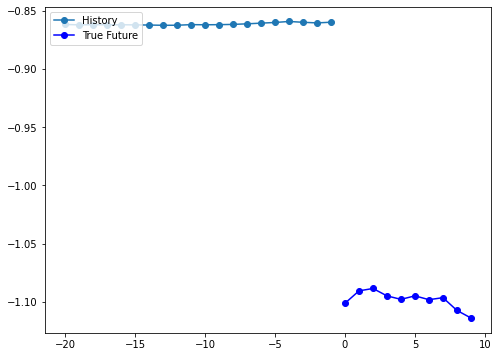

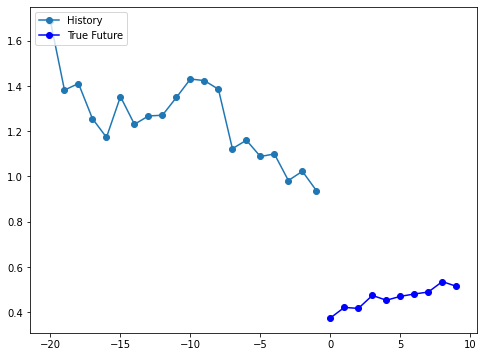

In [ ]:
for x,y in train_multi_2D.take(2):
  multi_step_plot(x[0], y[0], np.array([0]))

## Función que gráfica la perdida en los datos de entrenamiento y validación

In [ ]:
def plot_loss(history, title):
  #print(history.history)
  loss = history.history['loss']
  #print(loss)
  val_loss = history.history['val_loss']
  #print(val_loss)

  epochs = range(len(loss))
  #print(epochs)

  #1st y axis (training loss)
  fig, ax1 = plt.subplots()
  col1 = "red"
  ax1.set_xlabel("Epoch", size=15)
  ax1.set_ylabel("Training Loss", color=col1, size=20)
  ax1.plot(epochs,loss, color=col1, marker = 'o')
  ax1.tick_params(axis='y', labelcolor=col1)

  #2nd y axis (val loss)
  ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
  col2 = "blue"
  ax2.set_ylabel("Val. Loss", color=col2, size=20)
  ax2.plot(epochs, val_loss, color=col2, marker = "o")
  ax2.tick_params(axis='y', labelcolor=col2)
  plt.title(title, size=19)
  #fig.tight_layout()
  plt.show()

<a name="modelFunct"></a>
# Función(es) de creación del modelo RNN-LSTM
- Es un modelo con una capa intermedia.
- El modelo tiene como un argumento el número de neuronas de la capa intermedia.
- *Candidata a exportar*.

Volver a [Tabla de contenidos](#contents).

In [ ]:
def my_model_multi(n_of_neurons, in_shape, n_steps):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(units=n_of_neurons, input_shape=in_shape))
  model.add(tf.keras.layers.Dense(n_steps))
  return model

NOTA: Modelo con capa 2 capas intermedias:

In [ ]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

<a name="1stModels"></a>
#PRIMEROS MODELOS: Con 8, 128 y 256 neuronas.
- Para c/modelo se obtiene la gráfica de perdida para el entrenamiento y la validación.

Para el modelo de 8 neuronas se mostró:
- Resumen (summary) del modelo de 8 neuronas.
- Gráfica de compración de los datos versus predicción corta.

Volver a [Tabla de contenidos](#contents).

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 8 neuronas en su capa intermedia.

In [ ]:
%%time
#in_shape=x_train_multi_2D.shape[-2:]
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_2D_model = my_model_multi(n_of_neurons=8, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#TRAINING
#What does steps_per_epoch= mean ? why 200 'steps' ?
#What does validation= mean ? why 200 'steps' ?
print(f"Evaluation Threshold: {EVALUATION_INTERVAL}",
      f"Epochs: {EPOCHS}", sep="\n")

P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_multi_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions8U = multi_step_2D_model.predict(x_val_multi_2D)

Evaluation Threshold: 200
Epochs: 100
Epoch 1/100
200/200 [==============================] - 9s 8ms/step - loss: 0.6732 - val_loss: 5.4609
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.2345 - val_loss: 4.6884
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.1181 - val_loss: 4.2533
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 0.1023 - val_loss: 4.0340
Epoch 5/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0975 - val_loss: 3.9392
Epoch 6/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0955 - val_loss: 3.9027
Epoch 7/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0942 - val_loss: 3.8848
Epoch 8/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0935 - val_loss: 3.8908
Epoch 9/100
200/200 [==============================] - 1s 6ms/step - loss: 0.0926 - val_loss: 3.8942
Epoch 10/100
200/200 [==============================]

<a name="multistepPred"></a>
#Formato de las predicciones multipaso en un modelo con 8 neuronas.

Volver a [Tabla de contenidos](#contents).

[[1.1402428 1.137092  1.1459713 ... 1.1394168 1.1216389 1.1393733]
 [1.1869403 1.1794478 1.1871455 ... 1.1747991 1.1603799 1.1771557]
 [1.2458756 1.2360361 1.2493685 ... 1.2194829 1.2115921 1.2288064]
 ...
 [2.5159435 2.6104994 2.2504373 ... 2.2246242 2.2215512 2.1051342]
 [2.5140662 2.6396809 2.257309  ... 2.26215   2.242206  2.1104097]
 [2.5145197 2.6471717 2.2666025 ... 2.2685366 2.2466488 2.1191828]]
[[1.18607011 1.25190282 1.19159658 ... 1.24311449 1.24012797 1.26662654]
 [1.25190282 1.19159658 1.36952802 ... 1.24012797 1.26662654 1.2698104 ]
 [1.19159658 1.36952802 1.2089171  ... 1.26662654 1.2698104  1.27591041]
 ...
 [7.09139737 7.32335517 7.25344029 ... 6.81509591 6.7245967  6.7526968 ]
 [7.32335517 7.25344029 7.4347625  ... 6.7245967  6.7526968  6.81914733]
 [7.25344029 7.4347625  7.16156026 ... 6.7526968  6.81914733 6.57249115]]


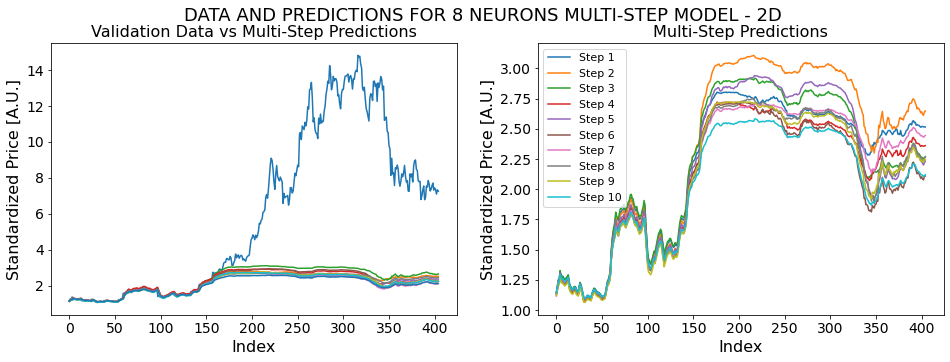

In [ ]:
print(predictions8U)
print(y_val_multi_2D)
#print(len(predictions8U[0,:]))
#print(predictions8U[0,:])
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16,5))
fig.suptitle("DATA AND PREDICTIONS FOR 8 NEURONS MULTI-STEP MODEL - 2D", size = 18)
ax1.set_title("Validation Data vs Multi-Step Predictions", size=16)
ax1.set_ylabel("Standardized Price [A.U.]", size=16)
ax1.set_xlabel("Index", size=16)
ax1.plot(y_val_multi_2D[:,0])
ax1.plot(predictions8U, label="s")
ax1.tick_params(labelsize = 14)
#ax1.set_xticks(fontsize = 15)
#plt.show()
ax2.set_title("Multi-Step Predictions", size=16)
ax2.set_ylabel("Standardized Price [A.U.]", size=16)
ax2.set_xlabel("Index", size=16)
#ax2.set_xlim(0,11)
#ax2.set_xlim(380,420)
#ax2.plot(predictions8U)
for i in range(len(predictions8U[0,:])): 
  ax2.plot(predictions8U[:,i], label="Step "+str(i+1))
ax2.tick_params(labelsize = 14)
plt.legend(fontsize = 11)
plt.show()

# NOTA: Algo raro
Las predicciones de cada paso deben estar desplazadas a la derecha entre mas grande sea el paso que se analiza, y esto no parece suceder (ver la gráfica anterior). Además, ver como son los datos de validación de la variable 'y' (target) y como se obtiene el MSE.

In [ ]:
print("--------- Parameters for 8 neurons model ---------")
print(multi_step_2D_model.summary())
#This is to understand the number of params
#print(320/8)
#print(x_train_single_uni.shape[-2:])
#single_step_1D_model = my_model(n_of_neurons=16, in_shape=x_train_single_uni.shape[-2:])
#single_step_1D_model.compile(optimizer='adam', loss='mae')
#print(single_step_1D_model.summary())
#print(1152/16)

--------- Parameters for 8 neurons model ---------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 8)                 352       
_________________________________________________________________
dense (Dense)                (None, 10)                90        
Total params: 442
Trainable params: 442
Non-trainable params: 0
_________________________________________________________________
None


### Gráfica de la pérdida en función de las epochs

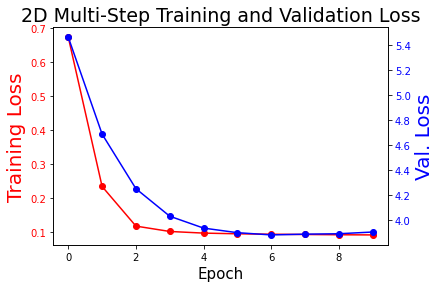

In [ ]:
plot_loss(history=multi_step_2D_history, title='2D Multi-Step Training and Validation Loss')

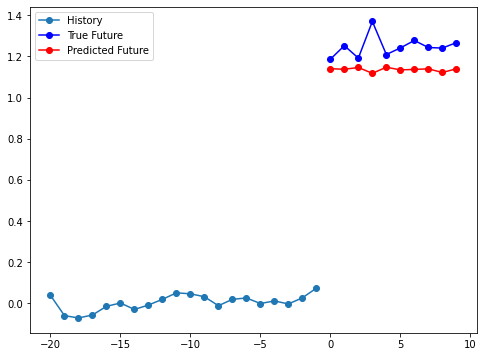

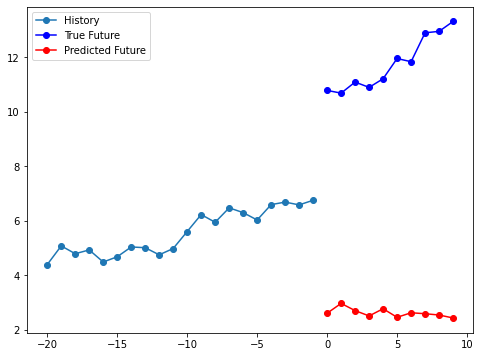

In [ ]:
#Checking sample prediction shape
for x,y in val_multi_2D.take(2):
  multi_step_plot(x[0],y[0], multi_step_2D_model.predict(x)[0])

In [ ]:
#deleting model
del multi_step_2D_model, multi_step_2D_history

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 128 neuronas en su capa intermedia.

In [ ]:
%%time
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_2D_model = my_model_multi(n_of_neurons=128, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_multi_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions128U = multi_step_2D_model.predict(x_val_multi_2D)

#deleting model
del multi_step_2D_model

Epoch 1/100
200/200 [==============================] - 3s 9ms/step - loss: 0.1702 - val_loss: 3.5783
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 0.1187 - val_loss: 3.2283
Epoch 3/100
200/200 [==============================] - 1s 7ms/step - loss: 0.1027 - val_loss: 3.1768
Epoch 4/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0917 - val_loss: 3.2423
Epoch 5/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0857 - val_loss: 3.2238
Epoch 6/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0802 - val_loss: 3.1257
Epoch 7/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0758 - val_loss: 3.1162
Epoch 8/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0721 - val_loss: 3.1234
Epoch 9/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0681 - val_loss: 3.1608
Epoch 10/100
200/200 [==============================] - 1s 7ms/step - loss: 0.0645 - val_lo

### Gráfica de la pérdida en función de las epochs

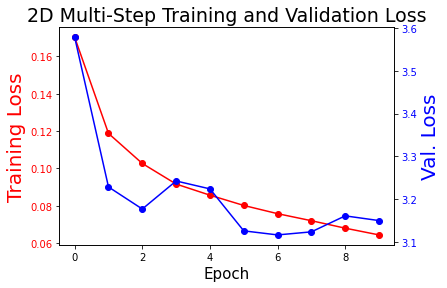

In [ ]:
plot_loss(history=multi_step_2D_history, title='2D Multi-Step Training and Validation Loss')
del multi_step_2D_history

### Creación del modelo, entrenamiento, predicción y eliminación del modelo con 256 neuronas en su capa intermedia.

In [ ]:
%%time
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_2D_model = my_model_multi(n_of_neurons=256, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_multi_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U = multi_step_2D_model.predict(x_val_multi_2D)

#deleting model
del multi_step_2D_model

Epoch 1/100
200/200 [==============================] - 4s 10ms/step - loss: 0.1780 - val_loss: 3.0490
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1167 - val_loss: 2.9622
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0988 - val_loss: 2.9842
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0882 - val_loss: 2.9730
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0804 - val_loss: 3.0755
CPU times: user 11.4 s, sys: 735 ms, total: 12.2 s
Wall time: 11 s


### Gráfica de la pérdida en función de las epochs

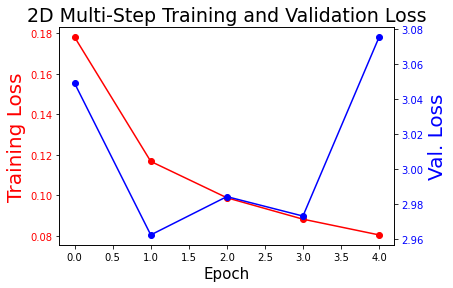

In [ ]:
plot_loss(history=multi_step_2D_history, title='2D Multi-Step Training and Validation Loss')
del multi_step_2D_history

<a name="1stPredPlots"></a>
# Primeras gráficas: Graficando predicciones (8, 128 y 256 neuronas) y mostrando errores (MSE)
- Gráficas de las predicciones de los modelos hechos anteriormente.

Volver a [Tabla de contenidos](#contents).

### Configurando dataframes para obtener series de tiempo (y no solo arrays):

In [ ]:
#To plot part of the train and validation data (from BTC only) together with models predictions

#------- Creating dframes (to work with time series) with standirized data
#dframes lengths
N = len(features)
M = len(predictions8U)
#print(N)
#print(M)

#data dataframe
data_std = pd.DataFrame(index=data.index, columns=['AdjCloStd'])
train_part = data_std[:TRAIN_SPLIT] #Not all train data, but just bitcoin train data
valid = data_std[TRAIN_SPLIT:]
#print(train_part)

#predictions dataframe
predictions = pd.DataFrame(index=data.tail(M).index, columns=['Pred8U','Pred128U','Pred256U'])

#print(features['BTC-USD'][1])
#Filling data dataframe
for i in range(0,N):
  data_std['AdjCloStd'][i] = dataset[:,0][i]#features['BTC-USD'][i]#uni_data#0 column is for btc_usd#

#print(train_part)
#print(data_std)
#NOTE: it is strange to me that train_part has something and it was not filled explicitely

#Filling predictions dataframe
predictions['Pred8U'] = predictions8U
predictions['Pred128U'] = predictions128U
predictions['Pred256U'] = predictions256U
#print(predictions)
#print(predictions8U)
#print(predictions8U[:,0])

### Mirando el formato de las predicciones

In [ ]:
print(predictions8U)
print(predictions['Pred8U'])
print(predictions128U)
print(predictions256U)

[[1.1093054 1.0778879 1.1021113 ... 1.0961635 1.075792  1.1118476]
 [1.0566918 1.0256491 1.0410534 ... 1.0520792 1.0293065 1.0626826]
 [1.037046  1.0132782 1.0272567 ... 1.0391481 1.016414  1.0457549]
 ...
 [2.5782018 2.637142  2.3101733 ... 2.284862  2.2207484 2.0810235]
 [2.57684   2.648253  2.306833  ... 2.3018174 2.2304943 2.0765061]
 [2.5779815 2.6440094 2.3074934 ... 2.296223  2.2282982 2.0762656]]
Date
2020-06-03    1.109305
2020-06-04    1.056692
2020-06-05    1.037046
2020-06-06    1.024165
2020-06-07    1.065816
                ...   
2021-07-09    2.597342
2021-07-10    2.572968
2021-07-11    2.578202
2021-07-12    2.576840
2021-07-14    2.577981
Name: Pred8U, Length: 403, dtype: float32
[[1.1699138 1.1668657 1.145775  ... 1.0949537 1.0359094 1.0299835]
 [1.1222854 1.1279311 1.1083367 ... 1.0615053 1.0027831 0.9969594]
 [1.1108385 1.1127094 1.0936934 ... 1.0466375 0.9881651 0.9817559]
 ...
 [4.714719  4.068508  3.9484928 ... 2.8973444 2.7232275 2.8434658]
 [4.6300693 4.02397

### Graficando serie de tiempo y predicciones:

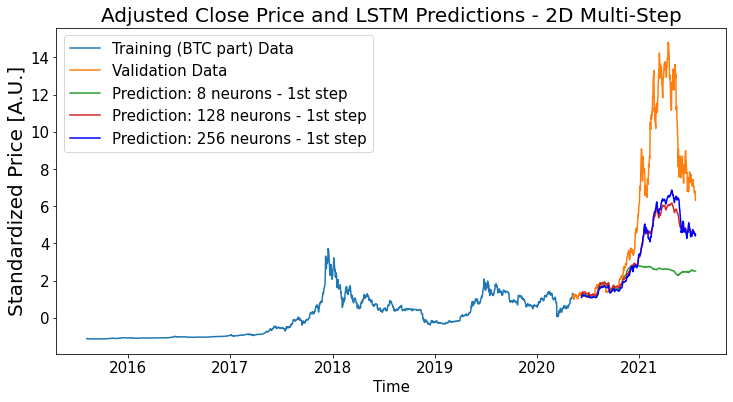

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train_part['AdjCloStd'], label="Training (BTC part) Data")
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="Prediction: 8 neurons - 1st step")
plt.plot(predictions['Pred128U'], label="Prediction: 128 neurons - 1st step")
plt.plot(predictions['Pred256U'], label="Prediction: 256 neurons - 1st step", color='blue')
plt.title("Adjusted Close Price and LSTM Predictions - 2D Multi-Step", size=20)
plt.ylabel("Standardized Price [A.U.]", size=20)
plt.xlabel("Time", size=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

### Graficando datos de validación y predicciones

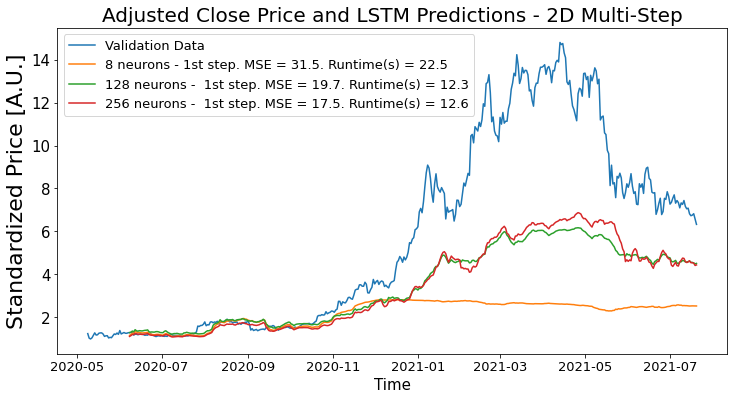

In [ ]:
#training time
T_8U = 22.5
T_128U = 12.3
T_256U = 12.6

#MSE Calculations
MSE_8U = round(mean_squared_error(y_val_multi_2D, predictions8U, squared=True),1)
MSE_128U = round(mean_squared_error(y_val_multi_2D, predictions128U, squared=True),1)
MSE_256U = round(mean_squared_error(y_val_multi_2D, predictions256U, squared=True),1)

#Plotting
plt.figure(figsize=(12,6))
plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(predictions['Pred8U'], label="8 neurons - 1st step. MSE = "+str(MSE_8U)+". Runtime(s) = "+str(T_8U))
plt.plot(predictions['Pred128U'], label="128 neurons -  1st step. MSE = "+str(MSE_128U)+". Runtime(s) = "+str(T_128U))
plt.plot(predictions['Pred256U'], label="256 neurons -  1st step. MSE = "+str(MSE_256U)+". Runtime(s) = "+str(T_256U))
plt.title("Adjusted Close Price and LSTM Predictions - 2D Multi-Step", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time", size=15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 13)
plt.show()
#NOTE: Destadarization NOT DONE

<a name="sameModels"></a>
# SEGUNDOS MODELOS (PROBLEMA): Predicciones de modelos "iguales" (con 256 y 2048 neuronas)
- Se muestran gráficas de predicciones de 6 modelos: 3 con 256 neuronas y 3 con 2048.
- Nota: Los cambios que se ven en la predicciones en el modelo de 2048 neuronas no son tan pronunciados como en los modelos a un paso.

Volver a [Tabla de contenidos](#contents).

#Para 256 neuronas:


In [ ]:
%%time
tf.keras.backend.clear_session()
units=256
###################### 1ND MODEL ##################################
#CREATING MODEL
multi_step_2D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_multi_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U_1 = multi_step_2D_model.predict(x_val_multi_2D)

#deleting model
del multi_step_2D_model, multi_step_2D_history

###################### 2ND MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_2D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_multi_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U_2 = multi_step_2D_model.predict(x_val_multi_2D)

#deleting model
del multi_step_2D_model, multi_step_2D_history

###################### 3RD MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_2D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_multi_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions256U_3 = multi_step_2D_model.predict(x_val_multi_2D)

#deleting model
del multi_step_2D_model, multi_step_2D_history

Epoch 1/100
200/200 [==============================] - 3s 10ms/step - loss: 0.1793 - val_loss: 2.9035
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1183 - val_loss: 3.2799
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0993 - val_loss: 3.1751
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0889 - val_loss: 3.1627
Epoch 1/100
200/200 [==============================] - 3s 11ms/step - loss: 0.1816 - val_loss: 2.9937
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1204 - val_loss: 2.9096
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1012 - val_loss: 3.0008
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0903 - val_loss: 3.1294
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0822 - val_loss: 3.0871
Epoch 1/100
200/200 [==============================] - 3s 10ms/step - loss: 0.1793 - val_

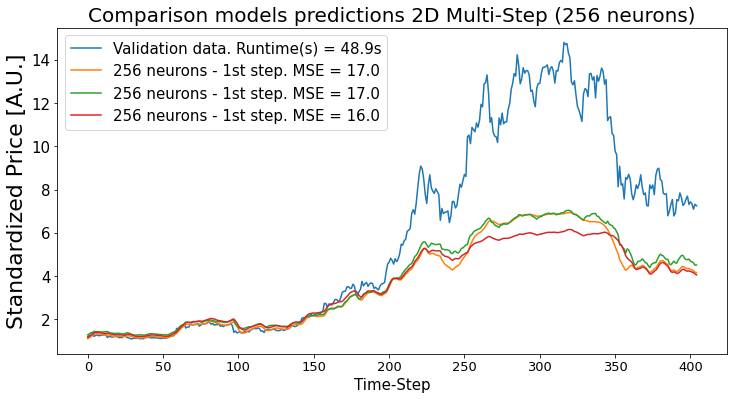

In [ ]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_256U_1 = round(mean_squared_error(y_val_multi_2D, predictions256U_1 , squared=True),1)
MSE_256U_2 = round(mean_squared_error(y_val_multi_2D, predictions256U_2 , squared=True),1)
MSE_256U_3 = round(mean_squared_error(y_val_multi_2D, predictions256U_3 , squared=True),1) 


#Plotting
plt.figure(figsize=(12,6))
plt.plot(y_val_multi_2D[:,0], label="Validation data. Runtime(s) = 48.9s")
plt.plot(predictions256U_1[:,0], label="256 neurons - 1st step. MSE = "+str(MSE_256U_1))
plt.plot(predictions256U_2[:,0], label="256 neurons - 1st step. MSE = "+str(MSE_256U_2))
plt.plot(predictions256U_3[:,0], label="256 neurons - 1st step. MSE = "+str(MSE_256U_3))
plt.title("Comparison models predictions 2D Multi-Step (256 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

#Para 2048 neuronas (anteriormente problemático):


In [ ]:
%%time
units=2048
###################### 1ND MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_2D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_multi_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions2048U_1 = multi_step_2D_model.predict(x_val_multi_2D)

#deleting model
del multi_step_2D_model, multi_step_2D_history

###################### 2ND MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_2D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_multi_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions2048U_2 = multi_step_2D_model.predict(x_val_multi_2D)

#deleting model
del multi_step_2D_model, multi_step_2D_history

###################### 3RD MODEL ##################################
tf.keras.backend.clear_session()
#CREATING MODEL
multi_step_2D_model = my_model_multi(n_of_neurons=units, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

#TRAINING
P=3
early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
#In my opinion "single_step_history" should be named as "single_step_fit"
multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data = val_multi_2D, callbacks=[early_stopping], 
                                            validation_steps=EVALUATION_INTERVAL)

#PREDICTIONS
predictions2048U_3 = multi_step_2D_model.predict(x_val_multi_2D)

#deleting model
del multi_step_2D_model, multi_step_2D_history

Epoch 1/100
200/200 [==============================] - 37s 176ms/step - loss: 0.6096 - val_loss: 4.6960
Epoch 2/100
200/200 [==============================] - 36s 178ms/step - loss: 0.3593 - val_loss: 4.5750
Epoch 3/100
200/200 [==============================] - 36s 181ms/step - loss: 0.3127 - val_loss: 4.6334
Epoch 4/100
200/200 [==============================] - 36s 182ms/step - loss: 0.3076 - val_loss: 4.7125
Epoch 5/100
200/200 [==============================] - 39s 194ms/step - loss: 0.2655 - val_loss: 4.2274
Epoch 6/100
200/200 [==============================] - 37s 187ms/step - loss: 0.2353 - val_loss: 4.5783
Epoch 7/100
200/200 [==============================] - 37s 187ms/step - loss: 0.1572 - val_loss: 3.9579
Epoch 8/100
200/200 [==============================] - 37s 187ms/step - loss: 0.1213 - val_loss: 4.0819
Epoch 9/100
200/200 [==============================] - 37s 187ms/step - loss: 0.1061 - val_loss: 4.0306
Epoch 10/100
200/200 [==============================] - 37s 187m

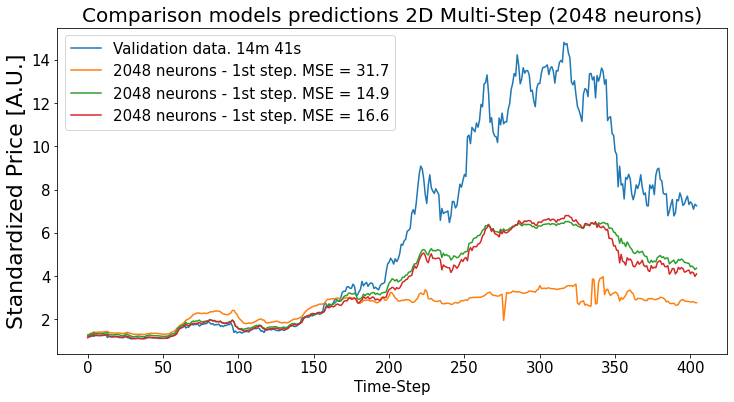

In [ ]:
###################### PLOTTING ##################################
#MSE Calculations
MSE_2048U_1 = round(mean_squared_error(y_val_multi_2D, predictions2048U_1 , squared=True),1)
MSE_2048U_2 = round(mean_squared_error(y_val_multi_2D, predictions2048U_2 , squared=True),1)
MSE_2048U_3 = round(mean_squared_error(y_val_multi_2D, predictions2048U_3 , squared=True),1) 


#Plotting
plt.figure(figsize=(12,6))
#plt.plot(valid['AdjCloStd'], label="Validation Data")
plt.plot(y_val_multi_2D[:,0], label="Validation data. 14m 41s")
plt.plot(predictions2048U_1[:,0], label="2048 neurons - 1st step. MSE = "+str(MSE_2048U_1))
plt.plot(predictions2048U_2[:,0], label="2048 neurons - 1st step. MSE = "+str(MSE_2048U_2))
plt.plot(predictions2048U_3[:,0], label="2048 neurons - 1st step. MSE = "+str(MSE_2048U_3))
plt.title("Comparison models predictions 2D Multi-Step (2048 neurons)", size=20)
plt.ylabel("Standardized Price [A.U.]", size=22)
plt.xlabel("Time-Step", size=15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

<a name="Errors"></a>

#Caracterizando el error (MSE) con modelos bivariados de 256 neuronas
- Se hicieron 100 número de simulaciones y se guardó el valor del MSE de cada simulación (en la variable errors).
- Histograma de los errores.
- Pruebas de normalidad.
- Bootstap (intervalo de confianza).

Volver a [Tabla de contenidos](#contents).

In [ ]:
%%time
N_SIM = 100
errors256_2D = []
for i in range(N_SIM):
  print("Simulation:"+str(i))
  tf.keras.backend.clear_session()
  #CREATING MODEL
  multi_step_2D_model = my_model_multi(n_of_neurons=256, in_shape=x_train_multi_2D.shape[-2:],n_steps=future_target)
  multi_step_2D_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
  
  #TRAINING
  P=3
  early_stopping = EarlyStopping(monitor="val_loss", patience=P, restore_best_weights=True)
  #In my opinion "single_step_history" should be named as "single_step_fit"
  multi_step_2D_history = multi_step_2D_model.fit(train_multi_2D, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                              validation_data = val_multi_2D, callbacks=[early_stopping], 
                                              validation_steps=EVALUATION_INTERVAL)

  #PREDICTIONS
  predictions256U = multi_step_2D_model.predict(x_val_multi_2D)

  #Calculating and saving errorsNOTDONE
  MSE = round(mean_squared_error(y_val_multi_2D, predictions256U , squared=True),2)
  errors256_2D.append(MSE)

  #deleting model
  del multi_step_2D_model, multi_step_2D_history

print(errors256_2D)

Simulation:0
Epoch 1/100
200/200 [==============================] - 3s 10ms/step - loss: 0.1773 - val_loss: 2.9836
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1178 - val_loss: 2.7741
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0993 - val_loss: 2.8383
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0893 - val_loss: 3.0199
Epoch 5/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0811 - val_loss: 3.0009
Simulation:1
Epoch 1/100
200/200 [==============================] - 3s 10ms/step - loss: 0.1752 - val_loss: 2.7836
Epoch 2/100
200/200 [==============================] - 2s 8ms/step - loss: 0.1169 - val_loss: 3.0195
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0988 - val_loss: 2.8894
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 0.0899 - val_loss: 3.0773
Simulation:2
Epoch 1/100
200/200 [=============================

---------- Histograma ----------


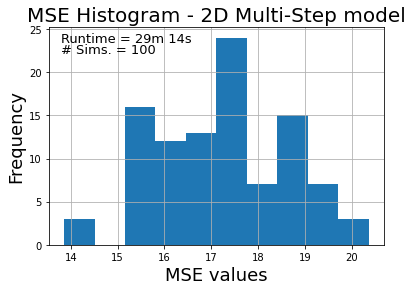

---------- Normality tests ----------
Shapiro-Wilk p-value for MSE:  0.3669816553592682
Kolmogorov-Smirnov p-value for MSE:  0.0
---------- Bootstrap ----------
17.2168
[16.945     17.4846025]
0.5396025000000009


In [ ]:
#Errors
print("---------- Histograma ----------")
xt = 13.8
errors256_2D = [15.47, 15.76, 17.11, 18.54, 17.29, 17.37, 17.63, 16.08, 17.38, 18.87, 15.24, 16.25, 17.11, 18.73, 18.92, 17.78, 17.14, 18.75, 17.13, 15.39, 13.86, 20.36, 15.5, 15.9, 19.06, 19.69, 15.97, 17.44, 14.07, 16.75, 17.41, 19.34, 17.04, 15.52, 16.16, 16.81, 18.64, 18.54, 17.9, 17.34, 16.04, 18.44, 18.55, 15.37, 17.3, 15.73, 19.08, 15.66, 17.73, 19.4, 17.8, 19.05, 15.55, 15.16, 16.81, 17.85, 13.87, 15.58, 15.49, 17.68, 18.68, 17.7, 16.34, 17.25, 18.03, 18.97, 17.49, 17.28, 16.81, 18.32, 19.93, 16.4, 15.36, 16.39, 15.8, 17.06, 16.45, 16.89, 16.8, 15.67, 15.91, 16.98, 17.62, 19.28, 18.8, 18.18, 17.3, 17.21, 17.51, 16.61, 18.65, 19.07, 16.68, 17.44, 19.92, 18.47, 17.18, 16.76, 16.35, 16.76]
plt.hist(errors256_2D)
#plt.title("Histograma de los Errores Cuadráticos Medios de Modelos 2D")
#plt.ylabel("Cuentas")
#plt.xlabel("Valores de MSE")
plt.title("MSE Histogram - 2D Multi-Step model", size = 20)
plt.ylabel("Frequency", size = 18)
plt.xlabel("MSE values", size = 18)
plt.text(xt, 23.5, "Runtime = 29m 14s", size = 13)
plt.text(xt, 22.2, "# Sims. = 100", size = 13)
plt.grid(True)
plt.show()

print("---------- Normality tests ----------")
staE, pvalE = stats.shapiro(errors256_2D)
print("Shapiro-Wilk p-value for MSE: ",pvalE)
staE, pvalE = stats.kstest(errors256_2D,'norm')
print("Kolmogorov-Smirnov p-value for MSE: ",pvalE)

print("---------- Bootstrap ----------")
random.seed(10)
bs_reps = dcst.draw_bs_reps(errors256_2D, np.mean, size = 10000)
conf_int = np.percentile(bs_reps, [2.5, 97.5])
print(np.mean(errors256_2D))
#print(np.median(errors256))
print(conf_int)
#print(conf_int-np.mean(errors256))
print(conf_int[1]-conf_int[0])

<a name="Conclu"></a>
#Conclusiones e ideas
### Conclusiones:

1. El modelo logra mejores predicciones cuando tiene mas neuronas en su capa intermedia, aunque las mejoras no parecen crecer tanto como en los modelos a un paso.
2. A diferencia de los modelos a un paso, los modelos con 2048 neuronas o menos arrojan predicciones no tan variables como se veía en los modelos a un paso inicialmente. Como lo llamamos en el equipo, las predicciones de los modelos multicapa utilizados no se "estallan".
3. Los resultados de las predicciones no son 100% repetibles. 
4. El intervalo de confianza (con un nivel de confianza del 95%) para la media del error de la predicción de las series bidimensionales multipaso en un modelo con 256 neuronas en su capa intermedia es 17.21 +/- (16.94, 17.48) con un $\Delta$Error = 0.54. Es decir aproximadamente 10 veces mas grande que el error en los modelos a un paso.
5. Los modelos a un paso arrojan mejores predicciones (con errores menores) que los modelos multipaso. Por ejemplo el modelo multipaso con una capa intermedia de 2048 neuronas arroja predicciones con mas error que el modelo a un paso con 256 neuronas en su capa intermedia (ambos modelo bivariados).


### Ideas:
1. Organizar al principio del documento 2 o 3 celdas donde se cargen la funciones y las variables necesarias para trabajar (de datos y de gráficas), y que no haya que cargar tantas celdas para poder correr los modelos (y también hacerlo en el cuaderno del análisis univariado).

Volver a [Tabla de contenidos](#contents).





## Bibliografía

### Redes RNN-LSTM (cuaderno).
1. [Introducción a Keras LSTM para series de tiempo multivariadas. Montenegro et.al.](https://nbviewer.jupyter.org/github/AprendizajeProfundo/Diplomado/blob/master/Temas/M%C3%B3dulo%205-%20Redes%20recurrentes/Cuadernos/rnrTimes_series_Multivariate.ipynb).
1. A. [Keras Timeseries Multi-Step Multi-Output](https://www.kaggle.com/nicapotato/keras-timeseries-multi-step-multi-output).

### Yahoo Finance (datos importados).
2. [Yahoo Finance API – A Complete Guide](https://algotrading101.com/learn/yahoo-finance-api-guide/)
3. [yfinance Library – A Complete Guide](https://algotrading101.com/learn/yfinance-guide/)
4. [yfinance documentation](https://pypi.org/project/yfinance/)

